### Introduction
In this challenge, I am tasked with using a restricted Boltzmann Machine (RBM) to perform feature extraction on an image based dataset.  We are not allowed to use MNIST or the iris datasets.  

The dataset I chose are chest x-rays of people with and without pneumonia, available on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).  

### 1 - Importing the data
The data from Kaggle is split into many subfolders.  The folders are split into training, validation, and test folders, with subfolders containing 'normal' and 'pneumonia' x-ray images.  Since the validation folder only had 8 images for each label, I decided to not include them here.  

In [1]:
import os 
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import sample 
from PIL import Image
from scipy.ndimage import convolve

from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [2]:
dirname = os.getcwd()

In [3]:
train_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/train/')
train_normal_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/train/NORMAL')
train_pnemonia_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

test_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/test/')
test_normal_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/test/NORMAL')
test_pnemonia_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/test/PNEUMONIA')

# train_path = os.path.join(dirname, 'chest_xray/train/')
# train_normal_path = os.path.join(dirname, 'chest_xray/train/NORMAL')
# train_pnemonia_path = os.path.join(dirname, 'chest_xray/train/PNEUMONIA')

# test_path = os.path.join(dirname, 'chest_xray/test/')
# test_normal_path = os.path.join(dirname, 'chest_xray/test/NORMAL')
# test_pnemonia_path = os.path.join(dirname, 'chest_xray/test/PNEUMONIA')

#### 1.1 - View the Images
I'm curious to see what the images look like...lets plot them!

In [4]:
def plot_images(dirpath, num_images = 10):
#     image_filename_lst = os.listdir(dirpath)[:num_images]
    image_filename_lst = sample(os.listdir(dirpath), num_images)
    full_filename_lst = [os.path.join(dirpath, file) for file in image_filename_lst]
    plt.figure(figsize = (13, 10))
    for i, img_path in enumerate(full_filename_lst):
        plt.subplot(5, 5, i+1)
        img = plt.imread(img_path)
        plt.xlabel(image_filename_lst[i])
        plt.imshow(img)
    plt.tight_layout()

The following 10 images are chest x-rays of people without pneumonia. 

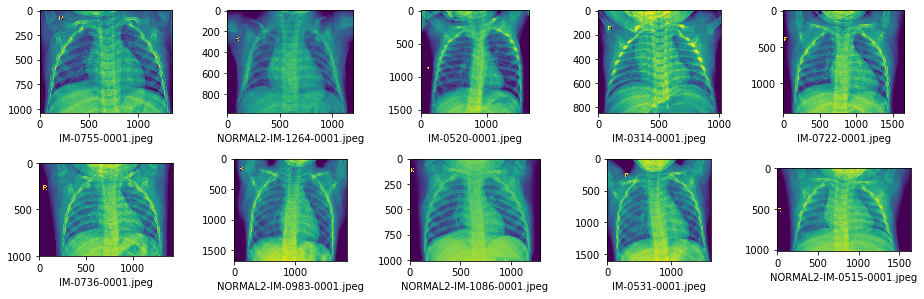

In [5]:
plot_images(train_normal_path)

And the following 10 images are chest x-rays with pneumonia.  Honestly, from my untrained eye, I have difficulty telling the normal and pneumonia x-rays apart.  I guess this is why doctors have to be so specialized.  

The one thing to note is that most of the images are green, there are some that are greyscale.

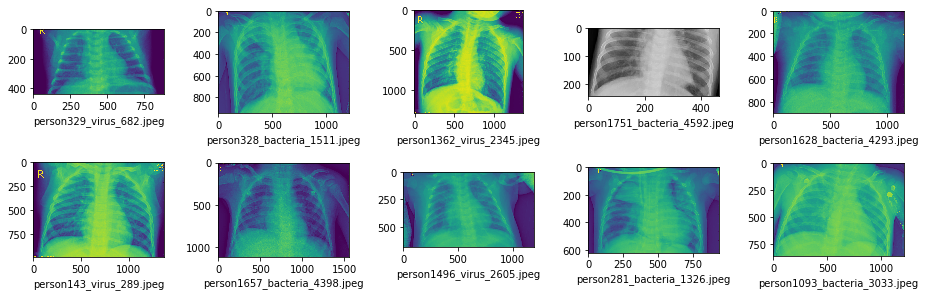

In [6]:
plot_images(train_pnemonia_path)

#### 1.2 - Collecting the Images
Right now, for both training and test sets, the normal and pneumonia images are in separate subfolders.  I want to create a training and test sets that have are well mixed.  For the training set, I have 500 images, and the test set there are 200 images.  The original images are also a whole variety of sizes.  I condense them all to 500 x 500, and converted to greyscale.

In [7]:
X_train_lst = []
y_train_lst = []

X_test_lst = []
y_test_lst = []

In [8]:
def get_images(dirpath, num_images = 500):
    image_filename_lst = sample(os.listdir(dirpath), num_images)
    full_filename_lst = [os.path.join(dirpath, file) for file in image_filename_lst]
    y = ''
    if dirpath.split('/')[-1] == 'NORMAL':
        y = 0
    else:
        y = 1
    if dirpath.split('/')[-2] == 'train':
        for file in full_filename_lst:
#             X_train_lst.append(file)
            im = Image.open(file).convert('L')
            im = im.resize((500, 500))
            im_values = np.asarray(im, 'float32').flatten()
            X_train_lst.append(im_values)
            y_train_lst.append(y)
#             im.close()
    if dirpath.split('/')[-2] == 'test':
        for file in full_filename_lst:
            im = Image.open(file).convert('L')
            im = im.resize((500, 500))
            im_values = np.asarray(im, 'float32').flatten()
            X_test_lst.append(im_values)
            y_test_lst.append(y)

In [9]:
get_images(train_normal_path)
get_images(train_pnemonia_path)

get_images(test_normal_path, num_images = 200)
get_images(test_pnemonia_path, num_images = 200)

What I've done so far is collected the images, flattened their pixels, and stored them in a list.  I will then put the pixels into a pandas dataframe, add the label, and then shuffle them.  

In [10]:
# train_df = pd.DataFrame({'imagename': X_train_lst, 'label': y_train_lst})
# test_df = pd.DataFrame({'imagename': X_test_lst, 'label': y_test_lst})
train_df = pd.DataFrame(X_train_lst)
test_df = pd.DataFrame(X_test_lst)

train_df['label'] = y_train_lst
test_df['label'] = y_test_lst

In [11]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

Just making sure everything is shuffled...and they are.

In [12]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,label
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
790,206.0,208.0,211.0,214.0,216.0,214.0,214.0,220.0,217.0,221.0,...,19.0,19.0,16.0,10.0,8.0,5.0,3.0,2.0,1.0,1
834,98.0,93.0,47.0,64.0,44.0,78.0,196.0,197.0,200.0,194.0,...,18.0,18.0,18.0,18.0,18.0,20.0,20.0,22.0,25.0,1
941,148.0,152.0,143.0,139.0,149.0,140.0,138.0,137.0,132.0,132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
598,33.0,33.0,33.0,34.0,34.0,35.0,35.0,36.0,36.0,36.0,...,36.0,29.0,30.0,26.0,30.0,28.0,24.0,20.0,18.0,1


In [13]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,label
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
64,32.0,34.0,34.0,37.0,39.0,41.0,41.0,45.0,50.0,49.0,...,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0
255,21.0,24.0,27.0,26.0,28.0,30.0,31.0,31.0,31.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
221,29.0,32.0,31.0,28.0,27.0,28.0,27.0,32.0,34.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### 2 - Preprocess the Data
Before I can dump the images into an RBM, I need to do some preprocessing first.  Now that everything is in greyscale, it is best to scale the pixels between 0 and 1.  Most people convert pixels to either black or white (pixels are either 0 or 1), but I don't think it would be beneficial in this case as it would wash out the important features in the lungs.  

In [15]:
def scale(df, epsilon = 0.0001):
#     X = np.asarray(X, 'float32')
    X = df.drop('label', axis = 1)
    y = df['label']
    X = (X - np.min(X, 0)) / (np.max(X, 0) + epsilon)
#     image = image > 0.5
#     image = image.astype(np.float32)
    return pd.concat([X, y], axis = 1)

In [16]:
train_df = scale(train_df)
test_df = scale(test_df)

### 3 - First Model
Finally, I can apply the first model!  I'm splitting the training set to a smaller training set and a validation set (to avoid confusion with my test set).  For the first model, I have arbitrarily chosen 100 components.  

In [17]:
logistic = LogisticRegression()
rbm = BernoulliRBM(n_components=100)
classifier = Pipeline([('rbm', rbm), ('logistic', logistic)])

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop('label', axis = 1), train_df['label'], test_size=0.2, random_state=42)

In [19]:
X_test = test_df.drop('label', axis = 1)
y_test = test_df['label']

In [20]:
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
y_test_pred = classifier.predict(X_test)

/home/crystal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Looking at the f1-scores for the training, validation, and test sets, they really aren't doing that great.  F1-scores are generally much higher for images with pneumonia compared to normal x-rays.

In [21]:
print('Training Score:  \n{}\n'.format(classification_report(y_train, y_train_pred)))
print('Validation Score:  \n{}\n'.format(classification_report(y_val, y_val_pred)))
print('Test Score:  \n{}'.format(classification_report(y_test, y_test_pred)))

Training Score:  
              precision    recall  f1-score   support

           0       0.59      0.25      0.35       383
           1       0.55      0.84      0.66       417

   micro avg       0.56      0.56      0.56       800
   macro avg       0.57      0.54      0.51       800
weighted avg       0.57      0.56      0.51       800


Validation Score:  
              precision    recall  f1-score   support

           0       0.67      0.28      0.40       117
           1       0.44      0.81      0.57        83

   micro avg       0.50      0.50      0.50       200
   macro avg       0.56      0.54      0.49       200
weighted avg       0.58      0.50      0.47       200


Test Score:  
              precision    recall  f1-score   support

           0       0.58      0.24      0.34       200
           1       0.52      0.82      0.64       200

   micro avg       0.53      0.53      0.53       400
   macro avg       0.55      0.53      0.49       400
weighted avg       0

Plotting the components below, a lot of them look like fuzzy blurs on a TV.  

A note:  the following code is mostly taken from sk-learn's website on [rbm classification](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py).

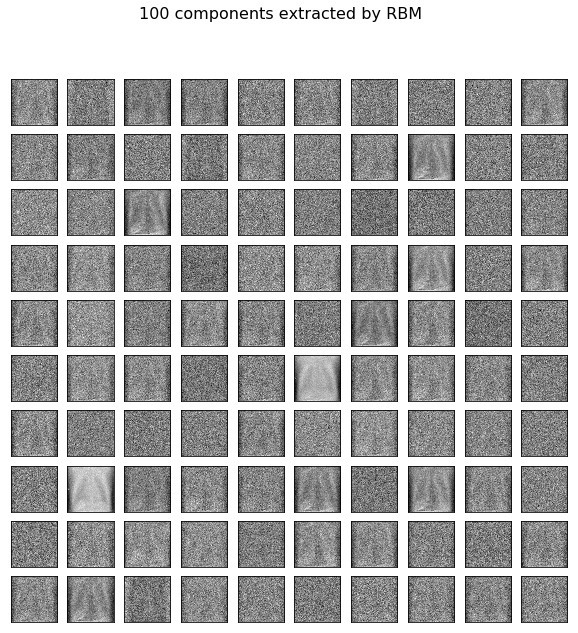

In [22]:
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((500, 500)), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.show()

### 4 - Improving the Model

#### 4.1 - Nudge Data
How can I improve the data?  A popular way is to gain more training data by augmenting the images (i.e. flipping or rotating images).  In this case, I will nudge the data up, left, right, and down one pixel to gain 5 times the amount of training images.  Again, this code is taken from [sk-learn's RBM classification page](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

In [23]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((500, 500)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


In [24]:
X_train, y_train = nudge_dataset(X_train, y_train)
X_val, y_val = nudge_dataset(X_val, y_val)
X_test, y_test = nudge_dataset(X_test, y_test)

In [25]:
logistic_nudged = LogisticRegression()
rbm_nudged = BernoulliRBM(n_components=100)
classifier_nudged = Pipeline([('rbm', rbm_nudged), ('logistic', logistic_nudged)])

In [26]:
classifier_nudged.fit(X_train, y_train)
y_train_pred_nudged = classifier_nudged.predict(X_train)
y_val_pred_nudged = classifier_nudged.predict(X_val)
y_test_pred_nudged = classifier_nudged.predict(X_test)

/home/crystal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


After training the data on the augmented/nudged dataset, the f1-scores of the normal x-rays now scores slightly better than the x-rays with pneumonia, although the f1-scores of those with pneumonia dropped slightly for all sets.  

In [27]:
print('Training Nudged Score:  \n{}\n'.format(classification_report(y_train, y_train_pred_nudged)))
print('Validation Nudged Score:  \n{}\n'.format(classification_report(y_val, y_val_pred_nudged)))
print('Test Nudged Score:  \n{}'.format(classification_report(y_test, y_test_pred_nudged)))

Training Nudged Score:  
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1915
           1       0.67      0.59      0.63      2085

   micro avg       0.64      0.64      0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.63      4000


Validation Nudged Score:  
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       585
           1       0.55      0.54      0.55       415

   micro avg       0.63      0.63      0.63      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.63      0.63      0.63      1000


Test Nudged Score:  
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      1000
           1       0.61      0.55      0.58      1000

   micro avg       0.60      0.60      0.60      2000
   macro avg       0.60      0.60      0.59      2000

A summary of the two models and their training and test f1-scores for normal (0) and pneumonia (1) images are summarized below.  In addition, the components of the augmented data are shown below.  While there are still many images that look fuzzy, more of them picked out areas around the spine as an important feature.  This makes sense as the affected areas of the lung are near the spine.  

Overall though, I suspect that RBM may not be the best choice for x-ray images in general if it is a common practice to create black and white images to feed the model, as this washes out any nuances in the x-ray.

| Model | training f1-score 0   | training f1-score 1|test f1-score 0   | test f1-score 1|
|------|------|
|   Base model  | 0.35 | 0.66 |0.34 |0.64 |
|   Augmented model  | 0.61|0.63 |0.61 |0.58 |


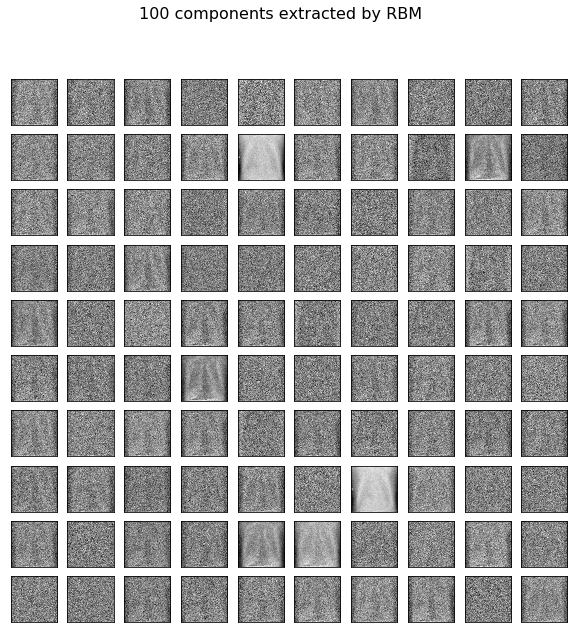

In [28]:
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm_nudged.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((500, 500)), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.show()